# PicnicHealth take-home analysis project

## How does weather change riding habits in San Francisco?

#### By: Arjun Shankar

This notebook presents a preliminary analysis of San Fransisco Bike Share data (https://www.fordgobike.com/system-data) and San Fransisco weather data (https://drive.google.com/file/d/1Pbm49OYLVUwelYgfC_czfYUavYr6U3oF/edit) pulled from  https://www.ncdc.noaa.gov/data-access/land-based-station-data. 

The goal is to determine __how weather changes riding habits in San Fransisco.__



## 1. Import and View data

In [1]:
import csv
import datetime as dt
import numpy as np
import pandas as pd
import os
import statistics
import matplotlib.pyplot as plt

import earthpy as et

import folium
from folium import plugins

import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling

Import bike csv data

In [2]:
bike_csv=[file for file in os.listdir() if file.endswith('tripdata.csv')]

In [3]:
bike_df=pd.DataFrame()
for item in bike_csv:
    df=pd.read_csv(item)
    bike_df=pd.concat([bike_df,df],sort=True)

List Bike Variables

In [4]:
bike_df.dtypes

bike_id                      int64
bike_share_for_all_trip     object
duration_sec                 int64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
end_station_name            object
end_time                    object
member_birth_year          float64
member_gender               object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
start_station_name          object
start_time                  object
user_type                   object
dtype: object

In [31]:
bike_df.head()

,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,start_date
0,1035,No,598,114.0,37.764478,-122.402570,Rhode Island St at 17th St,2018-03-01 00:09:45.187,1988.0,Male,284.0,37.784872,-122.400876,Yerba Buena Center for the Arts (Howard St at ...,2018-02-28 23:59:47.097,Subscriber,2018-02-28
1,1673,No,943,324.0,37.788300,-122.408531,Union Square (Powell St at Post St),2018-02-28 23:36:59.974,1987.0,Male,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2018-02-28 23:21:16.495,Customer,2018-02-28
2,3498,No,18587,15.0,37.795392,-122.394203,San Francisco Ferry Building (Harry Bridges Pl...,2018-02-28 23:30:42.925,1986.0,Female,93.0,37.770407,-122.391198,4th St at Mission Bay Blvd S,2018-02-28 18:20:55.190,Customer,2018-02-28
3,3129,No,18558,15.0,37.795392,-122.394203,San Francisco Ferry Building (Harry Bridges Pl...,2018-02-28 23:30:12.450,1981.0,Male,93.0,37.770407,-122.391198,4th St at Mission Bay Blvd S,2018-02-28 18:20:53.621,Customer,2018-02-28
4,1839,Yes,885,297.0,37.322980,-121.887931,Locust St at Grant St,2018-02-28 23:29:58.608,1976.0,Female,308.0,37.336802,-121.894090,San Pedro Square,2018-02-28 23:15:12.858,Subscriber,2018-02-28


View Bike Stations on Map

In [36]:
stations=bike_df.groupby('start_station_id')['start_station_latitude','start_station_longitude'].mean()

NameError: name 'bike_df' is not defined

In [7]:
print('There are ', len(bike_df.start_station_latitude.unique()), 'bike stations in San Fransisco')
m = folium.Map(
    location=[37.8174, -122.37],
    zoom_start=12,
    #tiles='Stamen Terrain'
)

tooltip = 'Click for Station ID'
for index in stations.index:
    folium.Marker([stations.start_station_latitude[index], stations.start_station_longitude[index]], popup='Station ID: '+str(index), tooltip=tooltip).add_to(m)

m


There are  419 bike stations in San Fransisco


Import Weather CSV

In [139]:
weather_df=pd.read_csv('NOAA_SF_weather.csv')

List Weather Variables

In [9]:
weather_df.dtypes

DATE                               object
HOURLYPrecip                      float64
HOURLYAltimeterSetting            float64
DAILYMaximumDryBulbTemp           float64
DAILYMinimumDryBulbTemp           float64
DAILYAverageDryBulbTemp           float64
DAILYDeptFromNormalAverageTemp    float64
DAILYHeatingDegreeDays            float64
DAILYCoolingDegreeDays            float64
DAILYSunrise                        int64
DAILYSunset                         int64
DAILYPrecip                       float64
dtype: object

In [118]:
weather_df.head()

,DATE,HOURLYPrecip,HOURLYAltimeterSetting,DAILYMaximumDryBulbTemp,DAILYMinimumDryBulbTemp,DAILYAverageDryBulbTemp,DAILYDeptFromNormalAverageTemp,DAILYHeatingDegreeDays,DAILYCoolingDegreeDays,DAILYSunrise,DAILYSunset,DAILYPrecip
0,2017-01-01 19:59,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725,1703,NaN
1,2017-01-01 23:59,NaN,NaN,52.0,45.0,48.0,-2.6,17.0,0.0,725,1703,0.05
2,2017-01-02 00:59,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725,1703,NaN
3,2017-01-02 03:59,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725,1703,NaN
4,2017-01-02 04:59,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725,1703,NaN


## 2. Data Cleaning

After examining the weather_df, it is clear that there are no entries for HOURLYAltimeterSetting. Furthermore, the DAILY average weather metrics are collected separately from HourlyPRECIP metrics. To simplify analysis, I will focus on the Daily Metrics first.

Create a Daily Weather DataFrame with only the Daily Average Weather Metrics

In [11]:
daily_weather_df=weather_df.dropna(axis=0, how='all', thresh=None, subset=['DAILYMaximumDryBulbTemp'], inplace=False)

In [12]:
daily_weather_df.drop(labels=['HOURLYPrecip','HOURLYAltimeterSetting'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Change Strings to datetime objects

In [13]:
daily_weather_df.DATE=[dt.datetime.strptime(date, '%Y-%m-%d %H:%M').date() for date in daily_weather_df.DATE]

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [14]:
bike_df['start_date']=[dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S.%f').date() for date in bike_df.start_time]
bike_df.start_time=[dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S.%f') for date in bike_df.start_time]
bike_df.end_time=[dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S.%f') for date in bike_df.end_time]


Merge the Daily Weather Data with the Bike Data

In [15]:
daily_bike_df=pd.merge(bike_df, daily_weather_df, left_on='start_date',right_on='DATE',how='inner')

Add a Column with the Day of the Week

In [16]:
daily_bike_df['day_of_week']=[date.isoweekday() for date in daily_bike_df.DATE]

In [2]:
#Save daily_bike_df 
#daily_bike_df.to_pickle('daily_bike_df.pkl')
daily_bike_df=pd.read_pickle('daily_bike_df.pkl')

## 3. Analysis

### 3.1 Separation of Weekday and Weekend Trends

First, I notice that Weekend Trends differ significantly from Weekday Trends. More rides are taken on Weekdays while Weekend rides are longer duration. I should be careful to use either Weekend or Weekday trends when comparing to weather trends.

In [3]:
# Define Weekday and Weekend Indices
Weekday=(daily_bike_df.groupby('DATE').day_of_week.mean() !=7) &(daily_bike_df.groupby('DATE').day_of_week.mean()!=6)
Weekend=(daily_bike_df.groupby('DATE').day_of_week.mean() ==7) |(daily_bike_df.groupby('DATE').day_of_week.mean()==6)

Text(0.5,0,'Date')

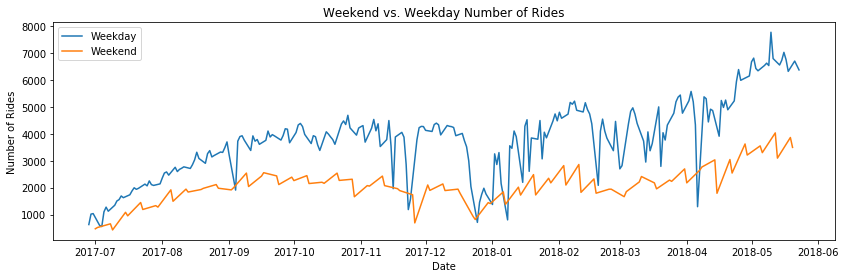

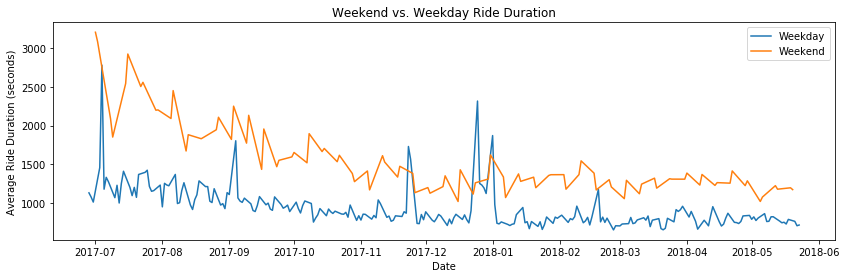

In [4]:
# Plot the Weekend vs. Weekday Number of Rides
f=plt.figure(figsize=(14,4))

daily_bike_df.groupby('DATE').duration_sec.count()[Weekday.values].plot()

daily_bike_df.groupby('DATE').duration_sec.count()[Weekend.values].plot()

plt.legend(['Weekday','Weekend'])
plt.title('Weekend vs. Weekday Number of Rides')
plt.ylabel('Number of Rides')
plt.xlabel('Date')

# Plot the Weekend vs. Weekday Ride Duration
f=plt.figure(figsize=(14,4))

daily_bike_df.groupby('DATE').duration_sec.mean()[Weekday.values].plot()

daily_bike_df.groupby('DATE').duration_sec.mean()[Weekend.values].plot()

plt.legend(['Weekday','Weekend'])
plt.title('Weekend vs. Weekday Ride Duration')
plt.ylabel('Average Ride Duration (seconds)')
plt.xlabel('Date')

### 3.2 Rough Exploratory Visualization

Here, I simply plot all of the numerical variables to quickly see if there are any interesting trends that jump out.

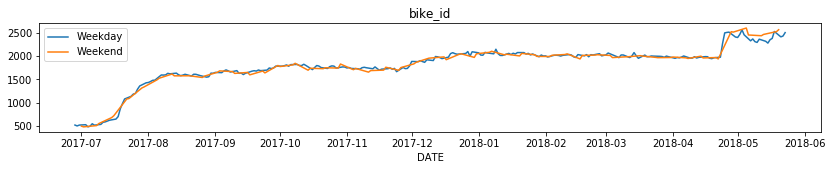

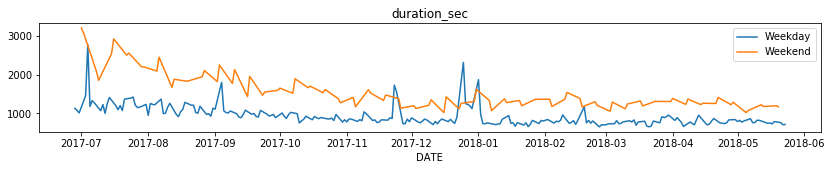

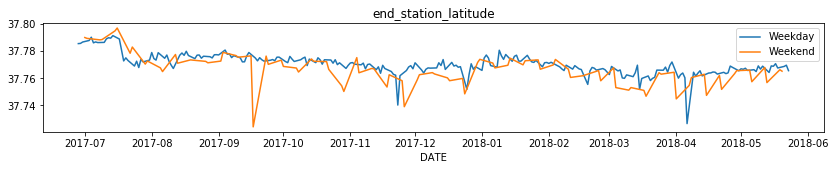

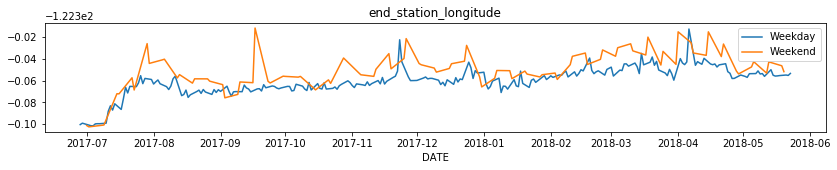

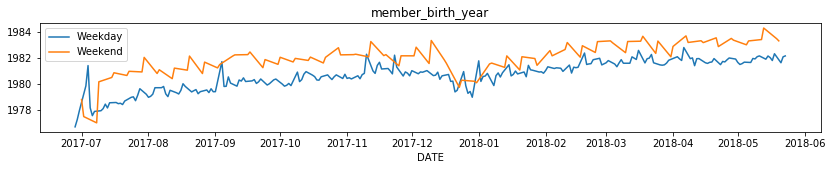

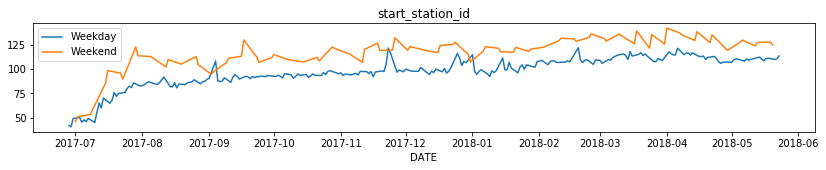

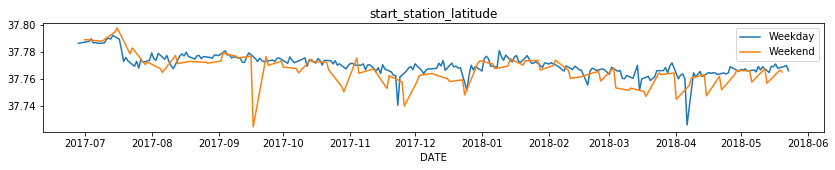

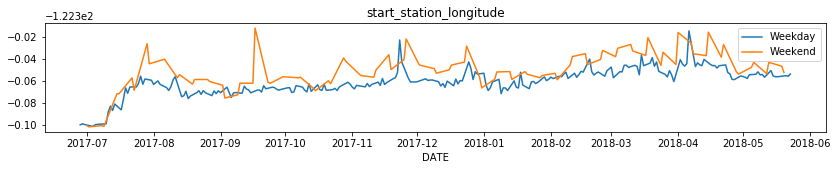

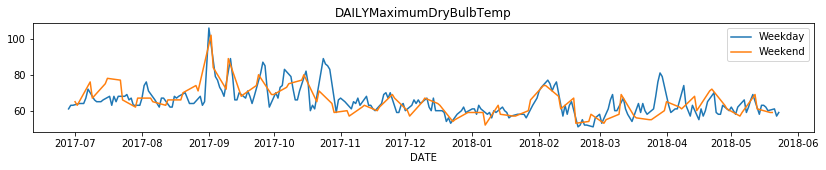

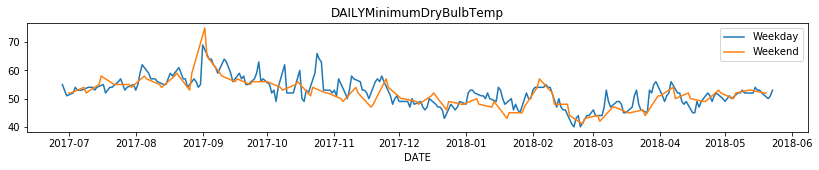

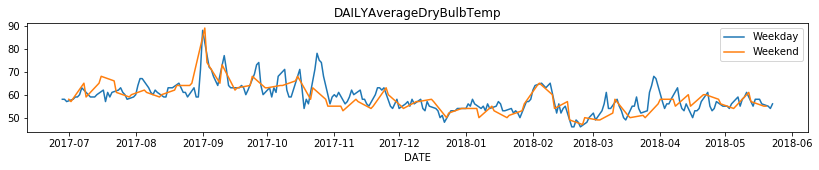

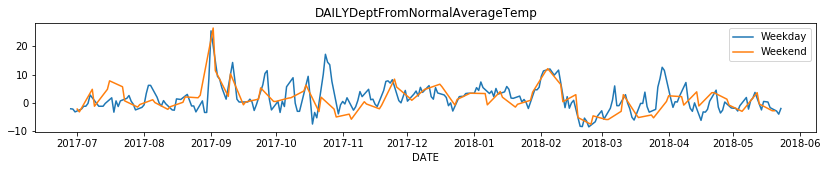

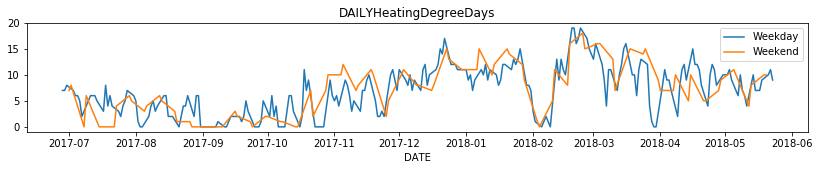

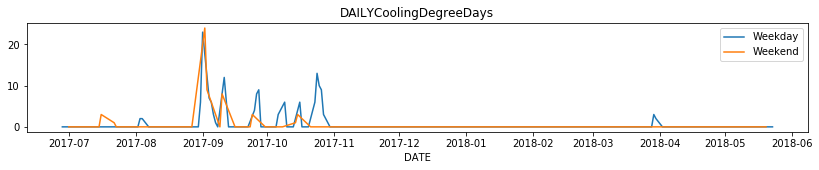

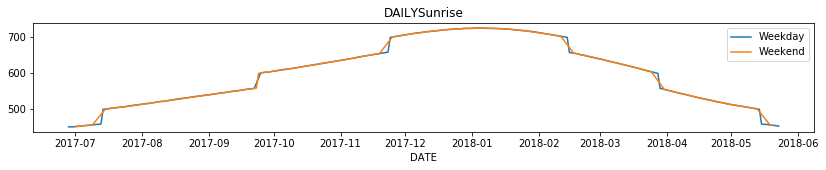

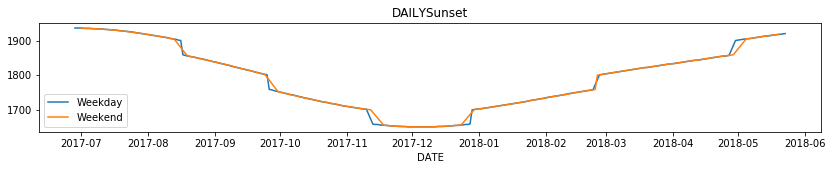

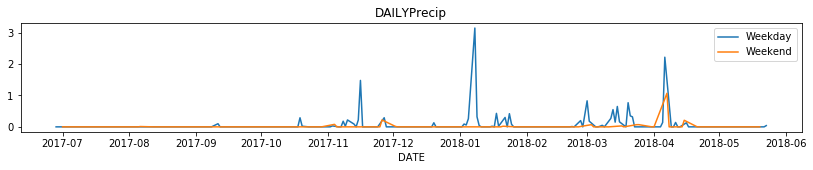

In [103]:
#Exploratory Data Visualization

for n in [0,4,5,8,10,11,12,18,19,20,21,22,23,24,25,26]:
    f=plt.figure(figsize=(14,2))
    a=daily_bike_df.columns[n]
    daily_bike_df.groupby('DATE')[a].mean()[Weekday.values].plot()
    daily_bike_df.groupby('DATE')[a].mean()[Weekend.values].plot()
    plt.legend(['Weekday','Weekend'])
    plt.title(a)

### 3.3 Hypothesis: Higher Precipitation will decrease number of rides on a given day as compared to the average number of rides in nearby days

To explore the hypothesis roughly, I plotted the number of rides taken and the daily precipitation with aligned x axis (dates). As the figure below shows, it appears that during rainy days, not as many rides are taken. To determine if there is a relationship, I will calculate the difference between number of rides taken on rainy days versus average number of rides taken 5 days before and after the given rainy day. It would not be informative to compare number of rides on rainy days vs. the overall average number of rides in the year as there is distinct seasonal variation in riding numbers. Therefore, it makes more sense to compare ride statistics on a given day to ride statistics on days near in time to that day.

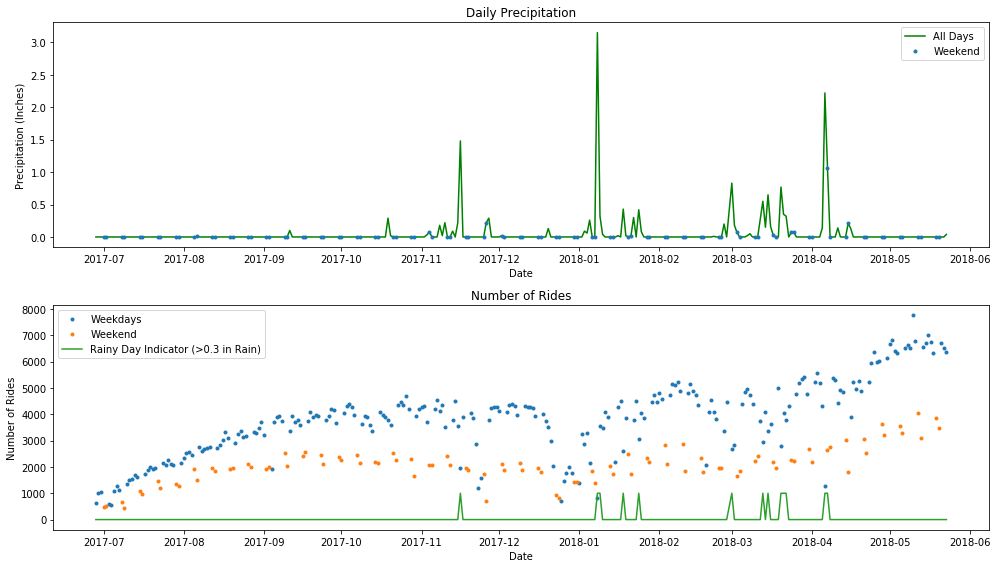

In [5]:
# Store dates in a variable for convenience when plotting
dates=np.array(list(daily_bike_df.groupby('DATE').groups.keys()))

# Plot the Daily Precipitation
f=plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(dates,daily_bike_df.groupby('DATE').DAILYPrecip.mean(),'g')
plt.plot(dates[Weekend.values],daily_bike_df.groupby('DATE').DAILYPrecip.mean()[Weekend.values],'.')
plt.legend(['All Days','Weekend'])

plt.title('Daily Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')

# Plot the Number of Rides on Weekends Weekdays
plt.subplot(2,1,2)
plt.plot(dates[Weekday.values],daily_bike_df.groupby('DATE').duration_sec.count()[Weekday.values],'.')
plt.plot(dates[Weekend.values],daily_bike_df.groupby('DATE').duration_sec.count()[Weekend.values],'.')

plt.plot(dates,(daily_bike_df.groupby('DATE').DAILYPrecip.mean()>0.3)*1000)
plt.legend(['Weekdays','Weekend','Rainy Day Indicator (>0.3 in Rain)'])


plt.title('Number of Rides')
plt.xlabel('Date')
plt.ylabel('Number of Rides')

plt.tight_layout()

### Having done some exploratory data analysis, I can now formulate a more specific hypothesis:

Null hypothesis: The Number of Rides will not decrease significantly on a rainy weekday (Precipitation>0.3 Inches) as compared to the 10 weekday average Number of Rides

Alterative hypothesis: The Number of Rides will decrease significantly on a rainy weekday (Precipitation>0.3 Inches) as compared to the 10 weekday average Number of Rides

Chosen Level of Significance $\alpha$ : 0.05 (95% confidence, Critical z Value =1.96,-1.96)

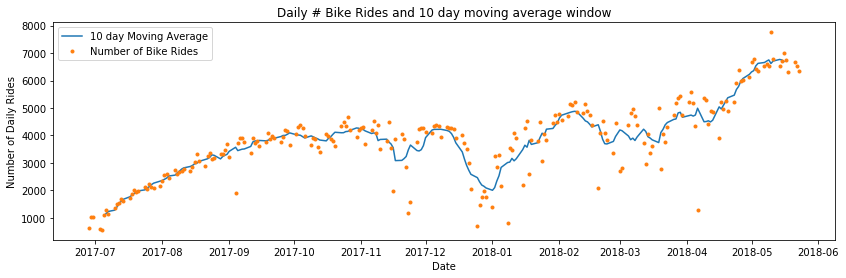

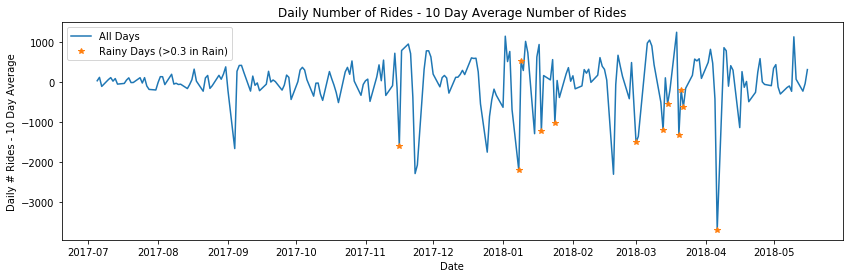

In [6]:
# Define Rainy Day Index
rainy=(daily_bike_df.groupby('DATE').DAILYPrecip.mean()>0.3)

# Create the distribution of all rainy weekday number of rides
y=daily_bike_df.groupby('DATE').duration_sec.count()[rainy.values & Weekday.values]

# Create a Kernel to Average Number of Rides in Windows of 10 days
N=10
kernel=np.ones(N+1)/N
kernel[int(N/2)]=0

x=np.convolve(daily_bike_df.groupby('DATE').duration_sec.count()[Weekday.values], kernel, mode='same')


#Plot the Moving Average Window of Ride Numbers
f=plt.figure(figsize=(14,4))

plt.plot(dates[Weekday.values][5:-5],x[5:-5])
plt.plot(dates[Weekday.values],daily_bike_df.groupby('DATE').duration_sec.count()[Weekday.values],'.')
plt.title('Daily # Bike Rides and 10 day moving average window')
plt.legend(['10 day Moving Average','Number of Bike Rides'])
plt.xlabel('Date')
plt.ylabel('Number of Daily Rides')

# Plot the Difference between Number of Rides on a Given day and the 10 day average centered on that day.
f=plt.figure(figsize=(14,4))

plt.plot(dates[Weekday.values][5:-5],daily_bike_df.groupby('DATE').duration_sec.count()[Weekday.values][5:-5]-x[5:-5])

plt.plot(dates[Weekday.values][(daily_bike_df.groupby('DATE').DAILYPrecip.mean()[Weekday.values]>0.3)],\
         y-x[(daily_bike_df.groupby('DATE').DAILYPrecip.mean()[Weekday.values]>0.3)],'*')

plt.title('Daily Number of Rides - 10 Day Average Number of Rides')
plt.xlabel('Date')
plt.ylabel('Daily # Rides - 10 Day Average')
plt.legend(['All Days','Rainy Days (>0.3 in Rain)'])


### 3.3 Finding:  The Number of Rides decreases significantly on a rainy weekday (Precipitation>0.3 Inches) as compared to the 10 weekday average Number of Rides (P< .00001)

In [7]:
# Calculate Significance

x_bar=np.mean(y-x[(daily_bike_df.groupby('DATE').DAILYPrecip.mean()[Weekday.values]>0.3)])
mu=np.mean(daily_bike_df.groupby('DATE').duration_sec.count()[Weekday.values][5:-5]-x[5:-5])
pop_std=np.std(daily_bike_df.groupby('DATE').duration_sec.count()[Weekday.values][5:-5]-x[5:-5])
n=len(y)

test_statistic=(x_bar-mu)/(pop_std/np.sqrt(n))

# Print Results of Significance Testing
print('\n sample mean: ', x_bar,
      '\n population mean: ', mu,
      '\n population std dev: ', pop_std,
      '\n sample size: ', n,
      '\n test statistic: ',test_statistic)
if test_statistic<-1.96:
    print('\n Since the test statistic: ',test_statistic,'is less than the critical value: -1.96,\n we can reject the null hypothesis')
else:
    print('\n Since the test statistic: ',test_statistic,'is not less than the critical value: -1.96,\n we cannot reject the null hypothesis')

    


 sample mean:  -1214.7416666666668 
 population mean:  5.1964444444442135 
 population std dev:  625.3239788111814 
 sample size:  12 
 test statistic:  -6.758080170061977

 Since the test statistic:  -6.758080170061977 is less than the critical value: -1.96,
 we can reject the null hypothesis


### 3.4 Hypothesis: Bridge Crossings will reduce significantly in heavy rain

The bike share data provided indicates that there are stations on both sides of the Oakland Bay Bridge.
We can count bridge crossings by selecting any rides that started in San Fransisco and ended in Oakland or the reverse. I looked up the longitude coordinates of Treasure Island on the middle of the bridge. As the map below shows, Anything with longitude greater than Treasure Island is in Oakland and anything with longitude less than Treasure Islands is in San Fransisco.

#### Dividing the Stations

In [40]:
stations=daily_bike_df.groupby('start_station_id')['start_station_latitude','start_station_longitude'].mean()
bridge_long=-122.3621
m = folium.Map(
    location=[37.8174, -122.37],
    zoom_start=12,
    #tiles='Stamen Terrain'
)

tooltip = 'Click for Station ID'
for index in stations.index:
    if stations.start_station_longitude[index]>bridge_long:
        folium.Marker([stations.start_station_latitude[index], stations.start_station_longitude[index]], popup='Station ID: '+str(index), tooltip=tooltip).add_to(m)
    else:
        folium.Marker([stations.start_station_latitude[index], stations.start_station_longitude[index]], popup='Station ID: '+str(index), tooltip=tooltip,icon=folium.Icon(color='red')).add_to(m)

m

### Plot the Rainy Days and Bridge Crossings

Here, I plot the Rainy Days and Bridge Crossings on the same axis to visually estimate if rain affects bridge crossing. I can vary the amount of precipitation I consider "rainy". Having visualized the data, I can now make a more specific hypothesis. I have chosen to ignore weekday vs. weekend differences here as there are so few bridge crossings to begin with.

#### Specific Bridge Crossing Hypothesis

Null hypothesis: The Number of Bridge Crossings will not decrease significantly on rainy days (Precipitation>1 Inch) as compared to the average Number of Bridge Crossings.

Alterative hypothesis: The Number of Bridge Crossings will decrease significantly on rainy days (Precipitation>1 Inch) as compared to the average Number of Bridge Crossings.

Chosen Level of Significance $\alpha$ : 0.05 (95% confidence, Critical z Value =1.96,-1.96)

In [98]:
#Define Rainy Day Index
rainy=(daily_bike_df.groupby('DATE').DAILYPrecip.mean()>1)

In [ ]:
#Calculate Bridge Crossings on Every Day
bridge_crossings=daily_bike_df[((daily_bike_df.start_station_longitude>bridge_long)& (daily_bike_df.end_station_longitude<bridge_long))\
| ((daily_bike_df.start_station_longitude<bridge_long)& (daily_bike_df.end_station_longitude>bridge_long))].groupby('DATE').duration_sec.count()
bridge_crossings=bridge_crossings[dates]
bridge_crossings[np.isnan(bridge_crossings)]=0

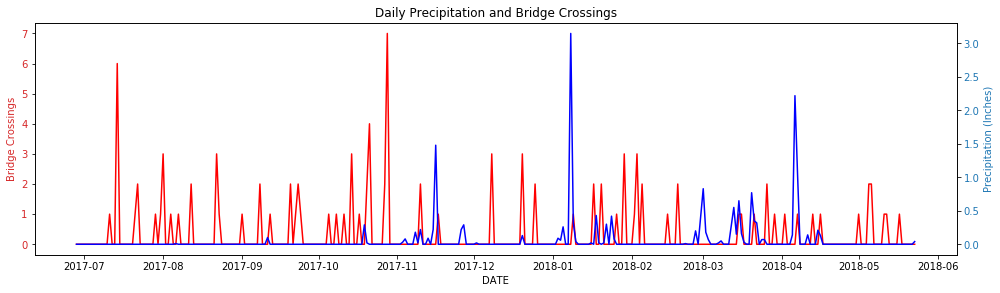

In [115]:
#Plot the Bridge Crossings and Rain on the same axis
fig, ax1 = plt.subplots(figsize=(14,4))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Bridge Crossings', color=color)

ax1.tick_params(axis='y', labelcolor=color)
bridge_crossings.plot(style='r')
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Precipitation (Inches)', color=color)

plt.plot(dates,daily_bike_df.groupby('DATE').DAILYPrecip.mean(),'b')

ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('Daily Precipitation and Bridge Crossings')
plt.show()

### 3.4 Finding:  The Number of Bridge Crossings does not decrease significantly on rainy days (Precipitation>1 Inch) as compared to the average Number of Bridge Crossings

In [111]:
# Calculate Significance

x_bar=np.mean(bridge_crossings[rainy.values])
mu=np.mean(bridge_crossings)
pop_std=np.std(bridge_crossings)
n=len(bridge_crossings[rainy.values])

test_statistic=(x_bar-mu)/(pop_std/np.sqrt(n))

# Print Results of Significance Testing
print('\n sample mean: ', x_bar,
      '\n population mean: ', mu,
      '\n population std dev: ', pop_std,
      '\n sample size: ', n,
      '\n test statistic: ',test_statistic)
if test_statistic<-1.96:
    print('\n Since the test statistic: ',test_statistic,'is less than the critical value: -1.96,\n we can reject the null hypothesis')
else:
    print('\n Since the test statistic: ',test_statistic,'is not less than the critical value: -1.96,\n we cannot reject the null hypothesis')

    


 sample mean:  0.25 
 population mean:  0.3100303951367781 
 population std dev:  0.8331594747239788 
 sample size:  4 
 test statistic:  -0.14410301258751418

 Since the test statistic:  -0.14410301258751418 is not less than the critical value: -1.96,
 we cannot reject the null hypothesis


### Who Crossed the bridge on the rainy day?

It appears that 1 person crossed the bridge on April 7, 2018, though it was rainy.

In [104]:
bridge_crossings[rainy.values]

DATE
2017-11-16    0.0
2018-01-08    0.0
2018-04-06    0.0
2018-04-07    1.0
Name: duration_sec, dtype: float64

In [109]:
daily_bike_df[((daily_bike_df.start_station_longitude>bridge_long)& (daily_bike_df.end_station_longitude<bridge_long))\
| ((daily_bike_df.start_station_longitude<bridge_long)& (daily_bike_df.end_station_longitude>bridge_long))]\
[daily_bike_df[((daily_bike_df.start_station_longitude>bridge_long)& (daily_bike_df.end_station_longitude<bridge_long))\
| ((daily_bike_df.start_station_longitude<bridge_long)& (daily_bike_df.end_station_longitude>bridge_long))]['DATE']==dt.date(2018,4,7)]

,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,...,DAILYMaximumDryBulbTemp,DAILYMinimumDryBulbTemp,DAILYAverageDryBulbTemp,DAILYDeptFromNormalAverageTemp,DAILYHeatingDegreeDays,DAILYCoolingDegreeDays,DAILYSunrise,DAILYSunset,DAILYPrecip,day_of_week
1067904,200,No,18119,3.0,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),2018-04-07 21:38:41.538,NaN,NaN,...,62.0,54.0,58.0,2.2,7.0,0.0,545,1839,1.07,6


### A Closer look at the Hourly Precipitation on the Rainy Day shows it was raining all day April 7, 2018

In [147]:
weather_df.DATE=[dt.datetime.strptime(date, '%Y-%m-%d %H:%M').date() for date in weather_df.DATE]

In [148]:
weather_df[weather_df.DATE==dt.date(2018,4,7)][['DATE','HOURLYPrecip','DAILYPrecip']]

,DATE,HOURLYPrecip,DAILYPrecip
1127,2018-04-07,0.21,NaN
1128,2018-04-07,0.34,NaN
1129,2018-04-07,0.20,NaN
1130,2018-04-07,0.18,NaN
1131,2018-04-07,0.10,NaN
1132,2018-04-07,0.04,NaN
1133,2018-04-07,NaN,1.07


## Conclusions

There are many questions that can be asked from this dataset. Here, I explored two relatively intuitive hypothesis relating weather and riding behavior. Part 3.2 showed that rain does decrease number of rides, as expected. Part 3.3 failed to show that rain decreases bridge crossings. I had initially thought that this finding was due to the one interpid biker who crossed the bridge on Sunday, April 7, 2018. However, even if he/she had not crossed the bridge that day(sample mean=0), the null hypothesis could not be rejected. This is probably because so few people ever cross the bridge by bike (on most days, bike crossings=0).

Overall, this project was really fun, and there is so much more that can be analyzed. Large amounts of data reveal unintuitive findings as well. For example, the average rider age is younger on the weekend than on weekdays! In the future, it would be interesting to determine how weather affects bike travel paths so that recommendations can be made regarding the optimal location of new bike stations. 